# O que podemos descobrir a partir da análise dos dadso geográficos de votação no Brasil?

## Análise Exploratória

In [1]:
import pandas as pd

# Lista dos arquivos para carregar
arquivos = [
    "df_candidatos.pkl",
    "df_microregioes.pkl",
    "df_municipios.pkl",
    "df_partidos.pkl",
    "df_votos.pkl"
]

# Função para exibir informações básicas
def explorar_dados(caminho):
    print(f"\n--- Explorando {caminho} ---")
    try:
        # Carregar o arquivo
        df = pd.read_pickle(caminho)
        
        # Exibir informações básicas
        print("Shape:", df.shape)
        print("Colunas:", df.columns.tolist())
        print("Primeiras linhas:")
        print(df.head(), "\n")
        
    except Exception as e:
        print(f"Erro ao carregar {caminho}: {e}")

# Explorar cada arquivo
for arquivo in arquivos:
    explorar_dados(arquivo)



--- Explorando df_candidatos.pkl ---
Shape: (546, 11)
Colunas: ['nome', 'numero_partido', 'nome_partido', 'sigla', 'genero', 'estado_civil', 'escolaridade', 'data_nascimento', 'raca', 'nome_urna', 'eleito']
Primeiras linhas:
                            nome  numero_partido  \
0         DANIEL TRZECIAK DUARTE              45   
1              ANY MACHADO ORTIZ              23   
2          ELVINO JOSE BOHN GASS              13   
3  ANTONIO CARLOS GOMES DA SILVA              10   
4   FRANCIANE ABADE BAYER MULLER              10   

                              nome_partido         sigla     genero  \
0  PARTIDO DA SOCIAL DEMOCRACIA BRASILEIRA          PSDB  MASCULINO   
1                                CIDADANIA     CIDADANIA   FEMININO   
2                PARTIDO DOS TRABALHADORES            PT  MASCULINO   
3                             REPUBLICANOS  REPUBLICANOS  MASCULINO   
4                             REPUBLICANOS  REPUBLICANOS   FEMININO   

  estado_civil         escolaridad

### vamos unir as tabelas dos votos e municípios para poder executar as consultas com mais facilidade.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar os dados
df_votos = pd.read_pickle('df_votos.pkl')
df_municipios = pd.read_pickle('df_municipios.pkl')
df_partidos = pd.read_pickle('df_partidos.pkl')

# Filtrar votos para eliminar partidos com votação muito baixa (por exemplo, votos abaixo de 100)
votos_totais = df_votos.groupby('nome_partido')['qt_votos'].sum()
partidos_com_votos = votos_totais[votos_totais > 100].index

# Filtrar os dados de votos para incluir apenas os partidos mais votados
df_votos_filtrado = df_votos[df_votos['nome_partido'].isin(partidos_com_votos)]

# Obter as legendas mais votadas (partido com mais votos em cada município)
df_votos_filtrado['max_votos'] = df_votos_filtrado.groupby('cd_mun')['qt_votos'].transform('max')
df_votos_filtrado = df_votos_filtrado[df_votos_filtrado['qt_votos'] == df_votos_filtrado['max_votos']]

# Juntar com os dados de municípios para obter indicadores socioeconômicos
df_votos_com_municipios = pd.merge(df_votos_filtrado, df_municipios, on='cd_mun')

# Exibir as primeiras linhas para conferir o merge
df_votos_com_municipios.head()


,cd_mun,nome,qt_votos,nome_partido,max_votos,gid,nm_mun,area_km2,geom,populacao,taxa_de_alfabetizacao,pib,pib_per_capita,renda_per_capita,homicidios_por_100_mil_hab,expectativa_de_vida_2010,idhm_2010,cd_micro
0,4301552,MAURICIO ALEXANDRE DZIEDRICKI,803,PODEMOS,803,31,Áurea,156.727,0106000000010000000103000000010000005907000009...,3396.0,0.972393,163438.0,48126.62,575.0,0.00,75.48,0.707,43004
1,4321634,GIOVANI CHERINI,397,PARTIDO LIBERAL,397,457,Três Arroios,148.601,0106000000010000000103000000010000004E03000043...,2591.0,0.970652,141196.0,54494.79,901.0,0.00,76.08,0.791,43004
2,4313359,JOSE ALFONSO EBERT HAMM,446,PROGRESSISTAS,446,286,Nova Roma do Sul,149.767,0106000000010000000103000000010000003E020000E8...,3466.0,0.973763,169304.0,48847.09,858.0,0.00,76.06,0.741,43016
3,4315156,MARCELO PIRES MORAES,799,PARTIDO LIBERAL,799,335,Progresso,256.039,010600000001000000010300000001000000DE020000CD...,5340.0,0.922463,166516.0,31182.77,580.0,32.07,76.66,0.683,43021
4,4314555,ADEMIR JOSE ANDRIOLI GONZATTO,269,PROGRESSISTAS,269,321,Pirapó,293.723,0106000000010000000103000000010000008B06000015...,2260.0,0.899120,94670.0,41889.38,460.0,0.00,74.46,0.669,43007


### Os seguintes gráficos mostram como a situação dos indicadores sociais de um municipio tendem a levá-lo a votar em um partido, e também a força da correlação entre os valores dos dados sociais e votos em um partido.

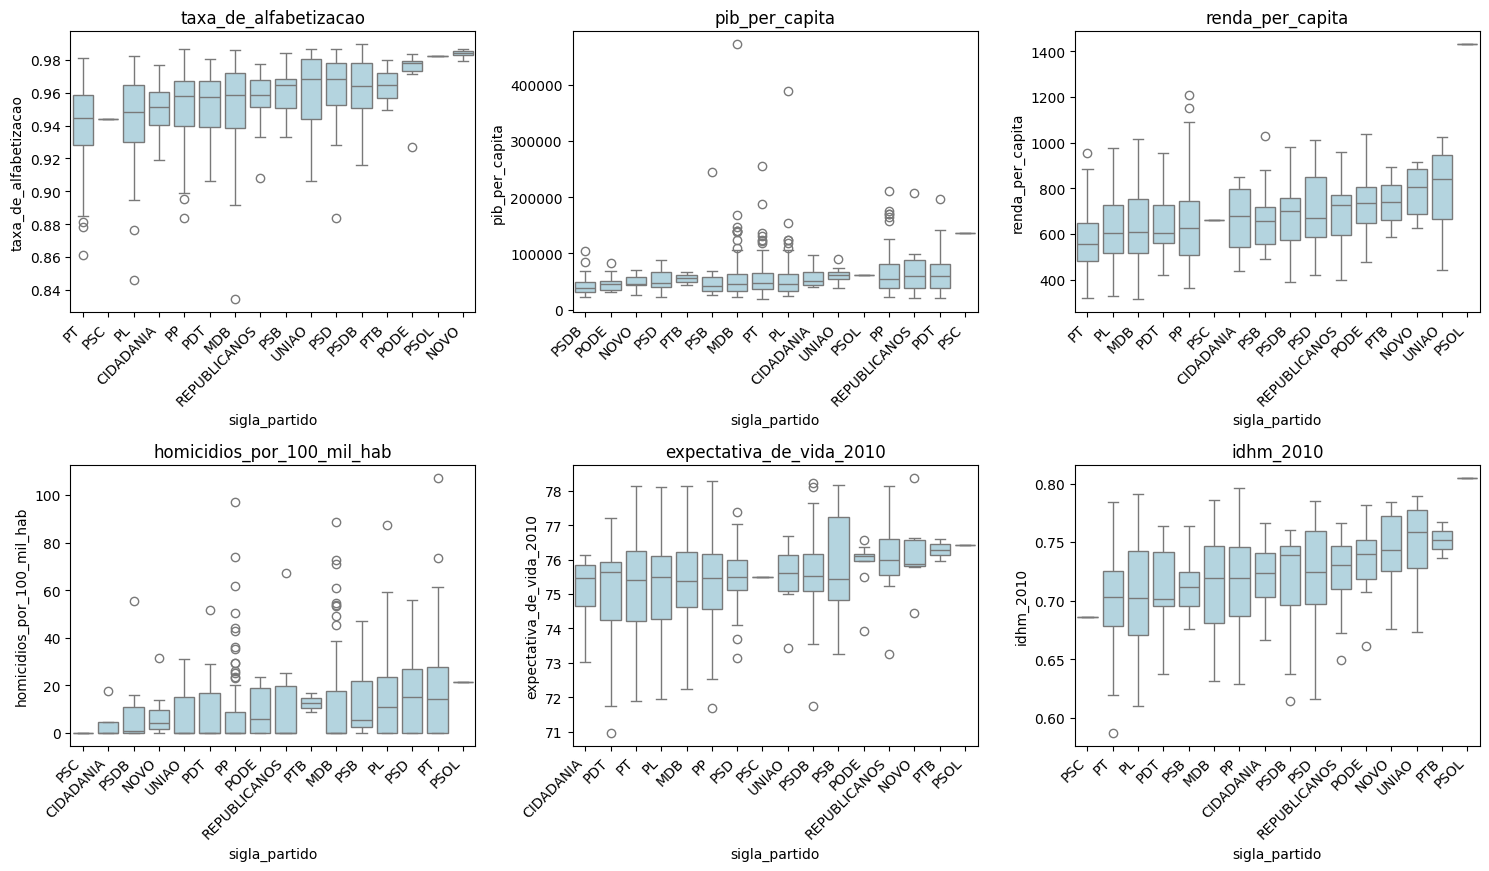

In [3]:
# Definir os indicadores sociais para analisar
indicadores = ['taxa_de_alfabetizacao', 'pib', 'pib_per_capita', 'renda_per_capita', 
               'homicidios_por_100_mil_hab', 'expectativa_de_vida_2010', 'idhm_2010']

# Carregar os DataFrames (df_votos, df_municipios, df_partidos)
# Assumindo que você já carregou os dados

# Mapeando as siglas dos partidos
sigla_map = dict(zip(df_partidos['nome'], df_partidos['sigla']))
df_votos_com_municipios['sigla_partido'] = df_votos_com_municipios['nome_partido'].map(sigla_map)

# Filtrando os indicadores, removendo 'pib'
indicadores = [indicador for indicador in indicadores if indicador != 'pib']

# Definir o tamanho da figura maior
plt.figure(figsize=(15, 12))

# Definir uma cor única para todos os gráficos
cor_unica = "lightblue"

# Criar os gráficos de boxplot para cada indicador
for i, indicador in enumerate(indicadores, 1):
    plt.subplot(3, 3, i)
    
    # Ordenar os dados pela média do indicador
    df_sorted = df_votos_com_municipios.groupby('sigla_partido')[indicador].mean().sort_values(ascending=True)
    
    # Plotar o boxplot com cor única
    sns.boxplot(x='sigla_partido', y=indicador, data=df_votos_com_municipios, order=df_sorted.index, color=cor_unica)
    
    # Título e ajustes de visualização
    plt.title(f'{indicador}')
    plt.xticks(rotation=45, ha='right')  # Rotacionar os nomes dos partidos para melhor visualização
    plt.tight_layout()  # Ajustar o layout para que os gráficos não se sobreponham

# Mostrar os gráficos
plt.show()


### Podemos medir numericamente quanto a situação em indicadores sociais de um municipio impacta na escolha de um partido.

In [4]:
import pandas as pd

# Mapeando as siglas dos partidos
sigla_map = dict(zip(df_partidos['nome'], df_partidos['sigla']))
df_votos_com_municipios['sigla_partido'] = df_votos_com_municipios['nome_partido'].map(sigla_map)

# Filtrando os indicadores, removendo 'pib'
indicadores = [indicador for indicador in indicadores if indicador != 'pib']

# Calcular a média dos indicadores socioeconômicos por partido, agora usando a sigla
media_indicadores_partido = df_votos_com_municipios.groupby('sigla_partido')[indicadores].mean()

# Calcular a correlação entre a quantidade de votos e os indicadores socioeconômicos
correlacoes = media_indicadores_partido.corrwith(df_votos_com_municipios.groupby('sigla_partido')['qt_votos'].sum())

# Criar uma lista para armazenar os resultados
resultados = []

# Para cada indicador, encontrar o partido com maior e menor valor
for indicador in indicadores:
    # Ordenar os partidos pela média do indicador
    df_sorted = media_indicadores_partido[indicador].sort_values(ascending=False)
    
    # Encontrar os partidos com maior e menor valor
    partido_lider = df_sorted.idxmax()
    partido_menor = df_sorted.idxmin()
    
    # Adicionar os resultados à lista
    resultados.append({
        'Dado': indicador,
        'Correlação (Valor Absoluto)': abs(correlacoes[indicador]),  # Corrigido para usar o valor absoluto
        'Partido com Maior Valor': partido_lider,
        'Partido com Menor Valor': partido_menor
    })

# Converter a lista de resultados em um DataFrame
resultados_df = pd.DataFrame(resultados)

# Ordenar os resultados pela correlação absoluta
resultados_sorted = resultados_df.reindex(resultados_df['Correlação (Valor Absoluto)'].sort_values(ascending=False).index)

# Exibir a tabela com os resultados, ordenada pela correlação absoluta
resultados_sorted


,Dado,Correlação (Valor Absoluto),Partido com Maior Valor,Partido com Menor Valor
3,homicidios_por_100_mil_hab,0.540885,PSOL,PSC
4,expectativa_de_vida_2010,0.305840,PSOL,CIDADANIA
1,pib_per_capita,0.272640,PSC,PSDB
0,taxa_de_alfabetizacao,0.271429,NOVO,PT
5,idhm_2010,0.175934,PSOL,PSC
2,renda_per_capita,0.113988,PSOL,PT


### A partir da introdução de um estudo que posiciona cada partido em um espectro político, é possível verificar se os fatores sociais de um município o influenciam não só a aderir a uma legenda, mas também os os eleitores de um municipio tendem a se posicionar ideologicamente

In [5]:
import pandas as pd

# Dados corrigidos com a média de cada partido
dados = {
    "Partido": ["PSTU", "PCO", "PCB", "PSOL", "PCdoB", "PT", "PDT", "PSB", "Rede", "PPS", "PV", "PTB", 
                "Avante", "SDD", "PMN", "PMB", "PHS", "MDB", "PSD", "PSDB", "Podemos", "PPL", "PRTB", "Pros", 
                "PRP", "PRB", "PR", "PTC", "DC", "PSL", "Novo", "Progressistas", "PSC", "Patriota", "DEM"],
    "Média": [0.51, 0.61, 0.91, 1.28, 1.92, 2.97, 3.92, 4.05, 4.77, 4.92, 5.29, 6.1, 6.32, 6.5, 6.88, 6.9, 
              6.96, 7.01, 7.09, 7.11, 7.24, 7.27, 7.45, 7.47, 7.59, 7.78, 7.78, 7.86, 8.11, 8.11, 8.13, 8.2, 
              8.33, 8.55, 8.57],
}

# Fonte: https://www.scielo.br/j/dados/a/zzyM3gzHD4P45WWdytXjZWg/?format=pdf&lang=pt

# Criando o DataFrame
df = pd.DataFrame(dados)

# Exibindo o DataFrame
print(df)

# Salvando em um arquivo CSV
df.to_csv('partido_alinhamento.csv', index=False)


          Partido  Média
0            PSTU   0.51
1             PCO   0.61
2             PCB   0.91
3            PSOL   1.28
4           PCdoB   1.92
5              PT   2.97
6             PDT   3.92
7             PSB   4.05
8            Rede   4.77
9             PPS   4.92
10             PV   5.29
11            PTB   6.10
12         Avante   6.32
13            SDD   6.50
14            PMN   6.88
15            PMB   6.90
16            PHS   6.96
17            MDB   7.01
18            PSD   7.09
19           PSDB   7.11
20        Podemos   7.24
21            PPL   7.27
22           PRTB   7.45
23           Pros   7.47
24            PRP   7.59
25            PRB   7.78
26             PR   7.78
27            PTC   7.86
28             DC   8.11
29            PSL   8.11
30           Novo   8.13
31  Progressistas   8.20
32            PSC   8.33
33       Patriota   8.55
34            DEM   8.57


In [6]:
# Normalizar as siglas para minúsculas para garantir que a comparação seja insensível a maiúsculas/minúsculas
df['Partido_normalizado'] = df['Partido'].str.lower()  # Normaliza a coluna de siglas no df

# Normalizar a coluna de sigla do df_partidos para minúsculas
df_partidos['sigla_normalizada'] = df_partidos['sigla'].str.lower()

# Fazer o join com base nas siglas normalizadas
df_merged = pd.merge(df, df_partidos, left_on='Partido_normalizado', right_on='sigla_normalizada', how='inner')

# Renomear a segunda coluna e ajustar a sigla para maiúsculas
df_merged['sigla_normalizada'] = df_merged['sigla_normalizada'].str.upper()  # Tornar as siglas em maiúsculas
df_merged.rename(columns={'Média': 'espectro_politico'}, inplace=True)

# Remover a coluna 'Partido_normalizado'
df_merged.drop(columns=['sigla_normalizada'], inplace=True)
df_merged.drop(columns=['Partido'], inplace=True)
df_merged.drop(columns=['Partido_normalizado'], inplace=True)

# Remover as linhas onde a coluna 'espectro_politico' está vazia
df_merged = df_merged.dropna(subset=['espectro_politico'])

# Exibir as primeiras linhas da tabela resultante
df_partidos_espectro = df_merged;
df_partidos_espectro.head()


,espectro_politico,nome,numero,sigla
0,0.51,PARTIDO SOCIALISTA DOS TRABALHADORES UNIFICADO,16,PSTU
1,0.61,PARTIDO DA CAUSA OPERARIA,29,PCO
2,0.91,PARTIDO COMUNISTA BRASILEIRO,21,PCB
3,1.28,PARTIDO SOCIALISMO E LIBERDADE,50,PSOL
4,2.97,PARTIDO DOS TRABALHADORES,13,PT


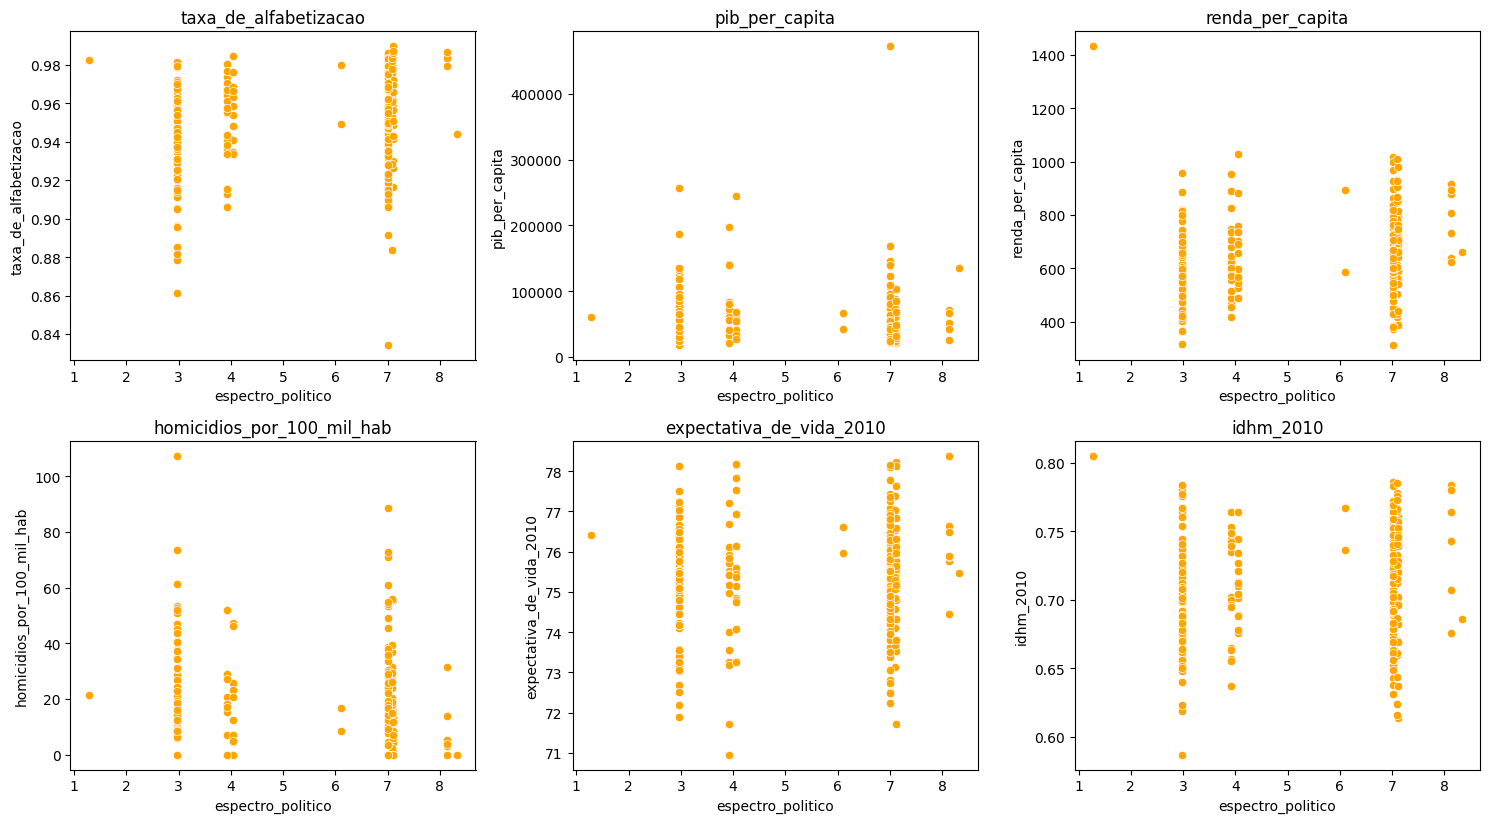

In [7]:
# Definir os indicadores sociais para analisar
indicadores = ['taxa_de_alfabetizacao', 'pib', 'pib_per_capita', 'renda_per_capita', 
               'homicidios_por_100_mil_hab', 'expectativa_de_vida_2010', 'idhm_2010']

# Carregar os DataFrames (df_votos, df_municipios, df_partidos_espectro)
# Assumindo que você já carregou os dados

# Mapeando as siglas dos partidos
sigla_map = dict(zip(df_partidos_espectro['nome'], df_partidos_espectro['sigla']))
df_votos_com_municipios['sigla_partido'] = df_votos_com_municipios['nome_partido'].map(sigla_map)

# Mapeando o espectro político dos partidos
espectro_map = dict(zip(df_partidos_espectro['nome'], df_partidos_espectro['espectro_politico']))
df_votos_com_municipios['espectro_politico'] = df_votos_com_municipios['nome_partido'].map(espectro_map)

# Filtrando os indicadores, removendo 'pib'
indicadores = [indicador for indicador in indicadores if indicador != 'pib']

# Definir o tamanho da figura maior
plt.figure(figsize=(15, 12))

# Definir uma cor única para todos os gráficos
cor_unica = "orange"

# Criar os gráficos de boxplot para cada indicador
# Criar os gráficos de dispersão para cada indicador
for i, indicador in enumerate(indicadores, 1):
    plt.subplot(3, 3, i)
    
    # Plotar o gráfico de dispersão com espectro político no eixo x e o indicador no eixo y
    sns.scatterplot(x='espectro_politico', y=indicador, data=df_votos_com_municipios, color=cor_unica)
    
    # Título e ajustes de visualização
    plt.title(f'{indicador}')
    plt.tight_layout()  # Ajustar o layout para que os gráficos não se sobreponham


# Mostrar os gráficos
plt.show()


### Mas de acordo com os dados, apesar de ser possível inferir quais partidos terão vantagem em um município a partir de indicadores sociais, não é possível inferir se uma localidade teria tendência a um espectro político-ideológico (direita-esquerda), porque os coeficientes de correlação nesse caso são muito baixos.

In [8]:
import pandas as pd

# Calcular a correlação de cada indicador com o espectro político
correlacoes = {}

for indicador in indicadores:
    correlacao = df_votos_com_municipios[indicador].corr(df_votos_com_municipios['espectro_politico'])
    correlacoes[indicador] = abs(correlacao)  # Valor absoluto da correlação

# Criar a tabela com os resultados
correlacoes_df = pd.DataFrame(list(correlacoes.items()), columns=['Dado', 'Correlação (Valor Absoluto)'])

# Ordenar a tabela por correlação (em ordem decrescente)
correlacoes_df = correlacoes_df.sort_values(by='Correlação (Valor Absoluto)', ascending=False)

# Exibir a tabela com formatação bonita
pd.set_option('display.float_format', '{:.6f}'.format)  # Definir a formatação dos números com 6 casas decimais
correlacoes_df


,Dado,Correlação (Valor Absoluto)
0,taxa_de_alfabetizacao,0.270923
2,renda_per_capita,0.192813
5,idhm_2010,0.151928
3,homicidios_por_100_mil_hab,0.119176
4,expectativa_de_vida_2010,0.076090
1,pib_per_capita,0.050376
